# Lab 2, Question 6

(6) Exercise: using an SVM model and the Landcare NZ 2024 landcover database, produce a landcover map of Great Barrier (Aotea) Island for 2025 (based off the Austral summer of 24/25).

Your map should be presented at a publication quality level with all the usual map components (scale, legend, north arrow, data attribution).

You will need to provide performance statistics of the model within your figure.

*   Here you can access the landcover database: https://lris.scinfo.org.nz/layer/104400-lcdb-v50-land-cover-database-version-50-mainland-new-zealand/. You will need to explore for yourself how to extract this data and then upload it to colab, then how to plug it into the SVM algorithim. I have provided some starter code below.

An intial workflow to get the data into the state you need it in to then use it as training data might look like:
- Download the ZIP manually from their browser, having set your area of interest and used the 'Export' tool top right.
- Upload it to Colab.
- Unzip it and load with GeoPandas.
(25 pts)


_______________________________________________________________________________


### Setup

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import userdata
    EE_PROJECT_ID = userdata.get('EE_PROJECT_ID') 
else:
    from dotenv import load_dotenv
    import os
    load_dotenv()  # take environment variables
    EE_PROJECT_ID = os.getenv('EE_PROJECT_ID')

# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project=EE_PROJECT_ID) #<- Remember to change this to your own project's name!

In [39]:
import tempfile
import urllib.request

from IPython.display import Image

import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.metrics import confusion_matrix, classification_report

# A. Read Data

### A.1. Load LCDB v5.0 - Land Cover Database version 5.0, Mainland, New Zealand for 2024

In [4]:
seed = 42  # Random seed for reproducibility

# Correct order: [xmin, ymin, xmax, ymax]
aoi = ee.Geometry.Rectangle([175.27, -36.36, 175.57, -36.01])

In [5]:
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    # Mask dilated clouds, cirrus, cloud, and cloud shadow
    mask = (qa.bitwiseAnd(1 << 1).eq(0)  # dilated
            .And(qa.bitwiseAnd(1 << 2).eq(0))  # cirrus
            .And(qa.bitwiseAnd(1 << 3).eq(0))  # cloud
            .And(qa.bitwiseAnd(1 << 4).eq(0)))  # shadow
    return image.updateMask(mask)

# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

l8 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
           .filterBounds(aoi)
           .filter(ee.Filter.lt('CLOUD_COVER', 10)))

l8_2018 = (l8
           .filterDate('2018-01-01', '2018-12-31')
           .map(mask_clouds)
           .map(apply_scale_factors)
           .median()
           .clip(aoi))

viz_rgb_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

### A.x Preparation classification data
#### Load data

In [6]:
# import zipfile
# import geopandas as gpd

# # Upload the ZIP manually using the Colab UI
# from google.colab import files
# uploaded = files.upload()  # <- Expects a ZIP

# Unzip
# with zipfile.ZipFile("LCDB_v5.zip", 'r') as zip_ref: #<- Check file names
#     zip_ref.extractall("lcdb")

# Read shapefile
gdf = gpd.read_file("../dataset/lris-lcdb-v50-land-cover-great-barrier-SHP/lcdb-v50-land-cover-database-version-50-mainland-new-zealand.shp")
df_2018 = gdf[['Name_2018', 'Class_2018', 'geometry', 'LCDB_UID']].copy()

#### Have a quick look

In [7]:
class_2018_lcdb = geemap.geopandas_to_ee(df_2018[['Class_2018', 'geometry']])

# rasterizes the data
class_2018_lcdb_image = class_2018_lcdb.reduceToImage(
    properties=['Class_2018'],
    reducer=ee.Reducer.first()
).rename('Class_2018').clip(aoi).toInt()

pixel_counts = l8_2018.updateMask(class_2018_lcdb_image).addBands(class_2018_lcdb_image).select('Class_2018').reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=aoi,
    scale=30,  # The spatial resolution of your imagery, in meters.
    maxPixels=1e9 # A large number to ensure all pixels are counted.
)

display(pixel_counts.getInfo())

{'Class_2018': {'1': 1192,
  '10': 12897,
  '12': 6,
  '16': 1206,
  '2': 318,
  '20': 22,
  '21': 100,
  '22': 1243,
  '33': 196,
  '40': 22912,
  '41': 5075,
  '45': 4403,
  '46': 2508,
  '5': 63,
  '51': 758,
  '52': 198722,
  '54': 64287,
  '6': 32,
  '64': 129,
  '69': 89235,
  '70': 1756,
  '71': 2203}}

=> The data is imbalance, and only a part (22/36 classes) of classes from original dataset.

### A.x Merge classes
- Reduce model complexity. SVM is natively aim to solve binary classification
- Reduce imbalancing of data => better performance

In [8]:
mapped_classes = {
    52: 1, # (Scrub) Manuka and/or Kanuka	                198,722
    33: 1, # (Scrub) Manuka and/or Kanuka                   196
    54: 1, # (Scrub) Broadleaved Indigenous Hardwoods	    64,287
    51: 1, # (Scrub) Gorse and/or Broom                     758
    69: 2, # (Forest) Indigenous Forest	                    89,235
    71: 2, # (Forest) Exotic Forest                         2,203
    40: 3, # (Grassland) High Producing Exotic Grassland    22,912
    41: 3, # (Grassland) Low Producing Grassland            5,075
    70: 4, # (Mangrove) Mangrove                            1,756
    10: 5, # (Bare) Sand or Gravel                          12,897
    16: 5, # (Bare) Gravel or Rock                          1,206
    64: 5, # (Bare) Forest - Harvested                      129
    12: 5, # (Bare) Landslide                               6
    45: 6, # (Herbaceous) Herbaceous Freshwater Vegetation  4,403
    46: 6, # (Herbaceous) Herbaceous Saline Vegetation      2,508
    22: 7, # (Water) Estuarine Open Water                   1,243
    21: 7, # (Water) River                                  100
    20: 7, # (Water) Lake or Pond                           22
    1: 8,  # (Urban) Built-up Area (settlement)             1,192
    2: 8,  # (Urban) Parkland/Open Space                    318
    5: 8,  # (Urban) Transport Infrastructure               63
    6: 9,  # (Other) Surface Mine or Dump                   32
}

In [9]:
# classes_2018 = df_2018['Class_2018'].unique().tolist()
# classes_2018.sort()  # Sort the unique classes
class_range = list(range(1, 10))  # Creates a list [1, 2, ..., 9]

class_property = 'class_mapped_2018'
df_2018[class_property] = df_2018['Class_2018'].map(lambda x: mapped_classes.get(x, 0))  # Map classes to new values, default to 0 if not found
df_2018

,Name_2018,Class_2018,geometry,LCDB_UID,class_mapped_2018
0,Indigenous Forest,69,"POLYGON ((1820024.501 6001139.3, 1820024.88 60...",lcdb1000168553,2
1,Sand or Gravel,10,"POLYGON ((1820044.213 6001276.335, 1820054.749...",lcdb1000009545,5
2,Indigenous Forest,69,"POLYGON ((1818865.334 6000862.483, 1818892.667...",lcdb1000168544,2
3,Sand or Gravel,10,"POLYGON ((1818859.62 6001650.91, 1818879.751 6...",lcdb1000009547,5
4,Indigenous Forest,69,"POLYGON ((1819208.841 5997374.363, 1819193.973...",lcdb1000168423,2
...,...,...,...,...,...
600,Broadleaved Indigenous Hardwoods,54,"POLYGON ((1815221.771 5992743.223, 1815178.566...",lcdb1000122604,1
601,Broadleaved Indigenous Hardwoods,54,"POLYGON ((1815222.725 5993078.074, 1815241.205...",lcdb1000122593,1
602,Broadleaved Indigenous Hardwoods,54,"POLYGON ((1815479.996 5993366.704, 1815438.725...",lcdb1000122624,1
603,High Producing Exotic Grassland,40,"POLYGON ((1815617.885 5995904.409, 1815612.303...",lcdb1000452551,3


### A.x Feature enhancement

In [10]:
# bands = ['B2', 'B3', 'B4', 'B8'] # Sentinel-2 bands: Blue, Green, Red, NIR
l8_bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

# bands = l8_bands
bands = l8_bands + ['NDVI', 'NDWI', 'EVI', 'SAVI', 'NBR']

# Calculate vegetation indices
def add_vegetation_indices(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('SR_B5'),
        'RED': image.select('SR_B4'),
        'BLUE': image.select('SR_B2')
    }).rename('EVI')
    savi = image.expression('1.5 * ((NIR - RED) / (NIR + RED + 0.5))', {
        'NIR': image.select('SR_B5'),
        'RED': image.select('SR_B4')
    }).rename('SAVI')
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')
    
    return image.addBands([ndvi, ndwi, evi, savi, nbr])

lcdb = geemap.geopandas_to_ee(df_2018[[class_property, 'geometry']])

# rasterizes the data
lcdb_image = lcdb.reduceToImage(
    properties=[class_property],
    reducer=ee.Reducer.first()
).rename(class_property).clip(aoi).toInt()

class_2018_lcdb_image = geemap.geopandas_to_ee(df_2018[['Class_2018', 'geometry']]) \
    .reduceToImage(
        properties=['Class_2018'],
        reducer=ee.Reducer.first()
    ).rename('Class_2018').clip(aoi).toInt()

# Apply scale factors so SR bands are in reflectance (approx 0-1)
# `lcdb` only covers land. Need to mark unlabled areas in `l8_2018`.
# l8_2018_lc = apply_scale_factors(l8_2018).updateMask(lcdb_image)
l8_2018_lc = l8_2018.updateMask(lcdb_image)

# Combine the bands of interest with the land cover data
# The `class_property` band will be used as our label
training_image = add_vegetation_indices(l8_2018_lc.addBands(lcdb_image))
#     .select(bands + [class_property])
    
# training_image = l8_2018_lc.addBands(lcdb_image)

### Visualize

In [11]:
Map = geemap.Map(center=[-36.1830, 175.3785], zoom=11)
Map.addLayer(aoi, {}, 'AOI')
Map.add_layer(
    class_2018_lcdb_image.select('Class_2018').randomVisualizer(), {}, 'LCDB v5.0 (2018)'
)
# Map.add_layer(
#     l8_2018, viz_rgb_params, 'l8_2018'
# )
Map.add_layer(
    training_image, viz_rgb_params, 'L8 2018 (Land Cover)'
)
Map.add_layer(
    training_image.select(class_property).randomVisualizer(), {}, 'Groupped - LCDB v5.0'
)
Map

Map(center=[-36.183, 175.3785], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topr…

### Training Data 

In [12]:
# # Sample the image to create training data
# # This will create a FeatureCollection where each feature has the pixel values 
# # for the bands and the corresponding land cover class.
training_data = training_image.select(bands + [class_property]).stratifiedSample(
    classBand=class_property,
    region=aoi,
    scale=30,  # The spatial resolution to sample at
    numPoints=250,  # The number of data points for each class
    seed=seed,  # Random seed for reproducibility
    geometries=True,  # Include the geometry of each sampled pixel
)

In [13]:
first_10 = training_data.limit(10).getInfo()

print('\nFirst 10 training samples:')
for i, feature in enumerate(first_10['features']):
    props = feature['properties']
    print(f"Sample {i+1}: Class={props[class_property]}, SR_B2={props['SR_B2']}, SR_B3={props['SR_B3']}, SR_B4={props['SR_B4']}, SR_B7={props['SR_B7']}")

# Count number of samples per class (server-side)
class_counts = training_data.reduceColumns(
    reducer=ee.Reducer.frequencyHistogram(),
    selectors=[class_property])

print('\nClass distribution in sample:')
print(class_counts.getInfo())


First 10 training samples:
Sample 1: Class=1, SR_B2=0.011915000000000009, SR_B3=0.021897499999999986, SR_B4=0.014142500000000002, SR_B7=0.035413749999999994
Sample 2: Class=1, SR_B2=0.011626250000000005, SR_B3=0.02881375, SR_B4=0.01671375, SR_B7=0.035138749999999996
Sample 3: Class=1, SR_B2=0.014444999999999986, SR_B3=0.02849750000000001, SR_B4=0.019504999999999995, SR_B7=0.04502500000000001
Sample 4: Class=1, SR_B2=0.01060875, SR_B3=0.023849999999999996, SR_B4=0.014431250000000007, SR_B7=0.032485
Sample 5: Class=1, SR_B2=0.0266275, SR_B3=0.04419999999999999, SR_B4=0.035454999999999987, SR_B7=0.08655000000000002
Sample 6: Class=1, SR_B2=0.01697499999999999, SR_B3=0.028414999999999996, SR_B4=0.021815, SR_B7=0.04945250000000001
Sample 7: Class=1, SR_B2=0.013743749999999999, SR_B3=0.03612874999999999, SR_B4=0.0234925, SR_B7=0.04671625
Sample 8: Class=1, SR_B2=0.013166250000000004, SR_B3=0.0281125, SR_B4=0.018019999999999994, SR_B7=0.04052875
Sample 9: Class=1, SR_B2=0.01063625, SR_B3=0.0

In [14]:
# Add random column
training_data = training_data.randomColumn('random')

# Split
train_set = training_data.filter(ee.Filter.lt('random', 0.8))
# valid_set = training_data.filter(ee.Filter.And(ee.Filter.gte('random', 0.7), ee.Filter.lt('random', 0.9)))
test_set = training_data.filter(ee.Filter.gte('random', 0.8))

# train_set = training_data.filter(ee.Filter.lt('random', 0.7))
# valid_set = training_data.filter(ee.Filter.And(ee.Filter.gte('random', 0.7), ee.Filter.lt('random', 0.9)))
# test_set = training_data.filter(ee.Filter.gte('random', 0.9))

In [21]:
svm = ee.Classifier.libsvm(kernelType='RBF', gamma=4, cost=500).train(
    features=train_set,
    classProperty=class_property,
    inputProperties=bands
)

In [22]:
# Get a confusion matrix and overall accuracy for the training sample.
train_accuracy = svm.confusionMatrix()
display('Training overall accuracy', train_accuracy.accuracy().getInfo())

'Training overall accuracy'

0.7298136645962733

Test to find gooo combination of `gamma` and `cost`.

In [ ]:
# gammas = [1, 2, 4, 8, 16, 32, 64]
# costs = [100, 200, 500, 1000, 30000, 50000, 100000]

# for gamma, cost in zip(gammas, costs):
#     svm = ee.Classifier.libsvm(kernelType='RBF', gamma=gamma, cost=cost).train(
#         features=train_set,
#         classProperty=class_property,
#         inputProperties=bands
#     )
    
#     print(f'Gamma: {gamma}, Cost: {cost}')
    
#     train_accuracy = svm.confusionMatrix()
#     print(f'Training overall accuracy: {train_accuracy.accuracy().getInfo()}')

#     # Classify the test set
#     test_classified = test_set.classify(svm)

#     # Get the confusion matrix
#     confusion_matrix = test_classified.errorMatrix(class_property, 'classification')

#     # Print the confusion matrix and accuracy
    
#     print('Overall Accuracy:', confusion_matrix.accuracy().getInfo())

In [23]:
### TESTING

# Austral summer of 24/25
l8_2025 = (l8
           .filterDate('2024-09-01', '2025-07-31')
           .map(mask_clouds)
           .median()
           .clip(aoi))

# Apply scale factors for consistency with training
# dl8_2025 = apply_scale_factors(l8_2025)

# l8_2025_classified = dl8_2025.updateMask(lcdb_image).classify(svm).select(l8_bands)

# l8_2018_classified = l8_2018_lc.classify(svm).select(l8_bands)

# Add vegetation indices to l8_2018_lc before classification
# l8_2018_lc_with_indices = add_vegetation_indices(l8_2018_lc)
l8_2018_classified = add_vegetation_indices(l8_2018_lc).classify(svm)

t_map = geemap.Map()
t_map.centerObject(aoi, 11)
# t_map.addLayer(dl8_2025, viz_rgb_params, '2025 RGB')
# t_map.addLayer(l8_2025_classified.randomVisualizer(), {}, '2025 Classified')
t_map.addLayer(l8_2018_lc, viz_rgb_params, '2018 RGB')
t_map.addLayer(l8_2018_classified.randomVisualizer(), {}, '2018 Classified')
t_map.addLayer(lcdb_image.randomVisualizer(), {} ,'LCDB v5.0')

t_map

Map(center=[-36.184963233625986, 175.41999999999973], controls=(WidgetControl(options=['position', 'transparen…

In [24]:
# display('Results of trained classifier', svm.explain())

In [29]:
# Get a confusion matrix and overall accuracy for the training sample.
train_accuracy = svm.confusionMatrix()
display('Training overall accuracy', train_accuracy.accuracy())

'Training overall accuracy'

In [26]:
test_classified = test_set.classify(svm)

# Function to export data for confusion matrix
def fc_to_lists(fc, classProp, predProp):
    values = fc.aggregate_array(classProp).getInfo()
    preds = fc.aggregate_array(predProp).getInfo()
    return values, preds

# Get predicted vs actual from test set
y_true, y_pred = fc_to_lists(test_classified, class_property, 'classification')


In [48]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_range)
report = classification_report(y_true, y_pred, labels=class_range, target_names=[str(l) for l in class_range], output_dict=True)

# Pretty-print
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=[f"Actual {l}" for l in class_range],
                       columns=[f"Pred {l}" for l in class_range]))
print("\nClassification Report:")
print(report)

Confusion Matrix:
          Pred 1  Pred 2  Pred 3  Pred 4  Pred 5  Pred 6  Pred 7  Pred 8  \
Actual 1      26      16       0       0       0       2       0       2   
Actual 2       9      42       0       0       1       0       0       3   
Actual 3       2       1      28       2       0       3       1      10   
Actual 4       4       2       0      44       1       0       6       4   
Actual 5       1       2       8       1      32       0       0       6   
Actual 6       9       0       4       3       3      30       0       0   
Actual 7       0       0       2       1       3       0      57       1   
Actual 8       5       1       6       0       0       2       0      32   
Actual 9       0       0       0       0       0       0       0       0   

          Pred 9  
Actual 1       0  
Actual 2       0  
Actual 3       0  
Actual 4       0  
Actual 5       0  
Actual 6       0  
Actual 7       0  
Actual 8       0  
Actual 9       4  

Classification Report:
{'1': {

In [32]:

# Evaluate test performance
test_matrix = test_classified.errorMatrix(class_property, 'classification')
# print("Confusion Matrix:")
# print(pd.DataFrame(test_matrix.getInfo(), index=[f"Actual {l}" for l in classes_2018],
#                        columns=[f"Pred {l}" for l in classes_2018]))
# print("\nClassification Report:")
# print(report)

# print('Error matrix:')
# print(test_matrix.getInfo())

# Compute accuracy metrics from the error matrix.
print('Overall accuracy:', test_matrix.accuracy().getInfo())
# print('Consumer\'s accuracy:')
# print(test_matrix.consumersAccuracy().getInfo())
# print('Producer\'s accuracy:')
# print(test_matrix.producersAccuracy().getInfo())
print('Kappa:', test_matrix.kappa().getInfo())

Overall accuracy: 0.6990521327014217
Kappa: 0.6565103699336016


In [33]:
# Austral summer of 24/25
l8_2025 = (l8
           .filterDate('2024-09-01', '2025-07-31')
           .map(mask_clouds)
           .map(apply_scale_factors)
           .median()
           .clip(aoi))

l8_2018_classified = add_vegetation_indices(l8_2025.updateMask(lcdb_image)).classify(svm)

l8_2025_classified = l8_2025.updateMask(lcdb_image).classify(svm)

In [36]:
# Classified image viz, fresh set up again to make sure we have exactly what we want displayed.


# Austral summer of 24/25
l8_2025_lc = (l8
           .filterDate('2024-09-01', '2025-07-31')
           .map(mask_clouds)
           .map(apply_scale_factors)
           .median()
           .updateMask(lcdb_image)
           .clip(aoi))

l8_2025_classified = add_vegetation_indices(l8_2025_lc).classify(svm)#.select(l8_bands)
l8_2018_classified = add_vegetation_indices(l8_2018_lc).classify(svm)

m = geemap.Map()
m.centerObject(aoi, 11)
m.addLayer(l8_2018_lc, viz_rgb_params, '2018 RGB')
m.addLayer(l8_2018_classified.randomVisualizer(), {}, '2018 Classified')
m.addLayer(l8_2025_lc, viz_rgb_params, '2025 RGB')
m.addLayer(l8_2025_classified.randomVisualizer(), {}, '2025 Classified')
m.addLayer(lcdb_image.randomVisualizer(), {} ,'LCDB v5.0')

m

Map(center=[-36.184963233625986, 175.41999999999973], controls=(WidgetControl(options=['position', 'transparen…

# B. Figures

In [62]:
classNames = [
    'Scrub',
    'Forest',
    'Grassland',
    'Mangrove',
    'Bare',
    'Herbaceous',
    'Water',
    'Urban',
    'Other',
]

classPalette = [
    '006400',
    'ffbb22',
    'ffff4c',
    'f096ff',
    'fa0000',
    'b4b4b4',
    '0064c8',
    '0096a0',
    'fae6a0',
]

vis_params = {
    'min': 1,
    'max': 9,
    'palette': classPalette
}

thumb_params = vis_params | {
    'dimensions': 512,
    'region': aoi,
    'format': 'png',
}

coords = aoi.coordinates().getInfo()[0]
lons = [pt[0] for pt in coords]
lats = [pt[1] for pt in coords]
xmin, xmax, ymin, ymax = min(lons), max(lons), min(lats), max(lats)

### B.1. Images

Classified Images

In [58]:
classified_imgs = []

for classified in [l8_2018_classified, l8_2025_classified]:
    # Download the image for the year
    url = classified.getThumbURL(thumb_params)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        urllib.request.urlretrieve(url, f.name)
        img = mpimg.imread(f.name)
        classified_imgs.append(img)
    display(Image(url=url))

Ground Truth Images

In [64]:

based_url = lcdb_image.getThumbURL(thumb_params)
with tempfile.NamedTemporaryFile(suffix=".png") as f:
    urllib.request.urlretrieve(based_url, f.name)
    based_img = mpimg.imread(f.name)
display(Image(url=based_url))

### B.3. Validation data

In [51]:
rows = ['accuracy', 'macro avg', 'weighted avg']
cols = ['precision', 'recall', 'f1-score']
df_report = pd.DataFrame(report)[rows]

df_plot = df_report.transpose()[cols]
df_plot

,precision,recall,f1-score
accuracy,0.699052,0.699052,0.699052
macro avg,0.735530,0.720492,0.722852
weighted avg,0.719441,0.699052,0.703691


### B.4. Plot

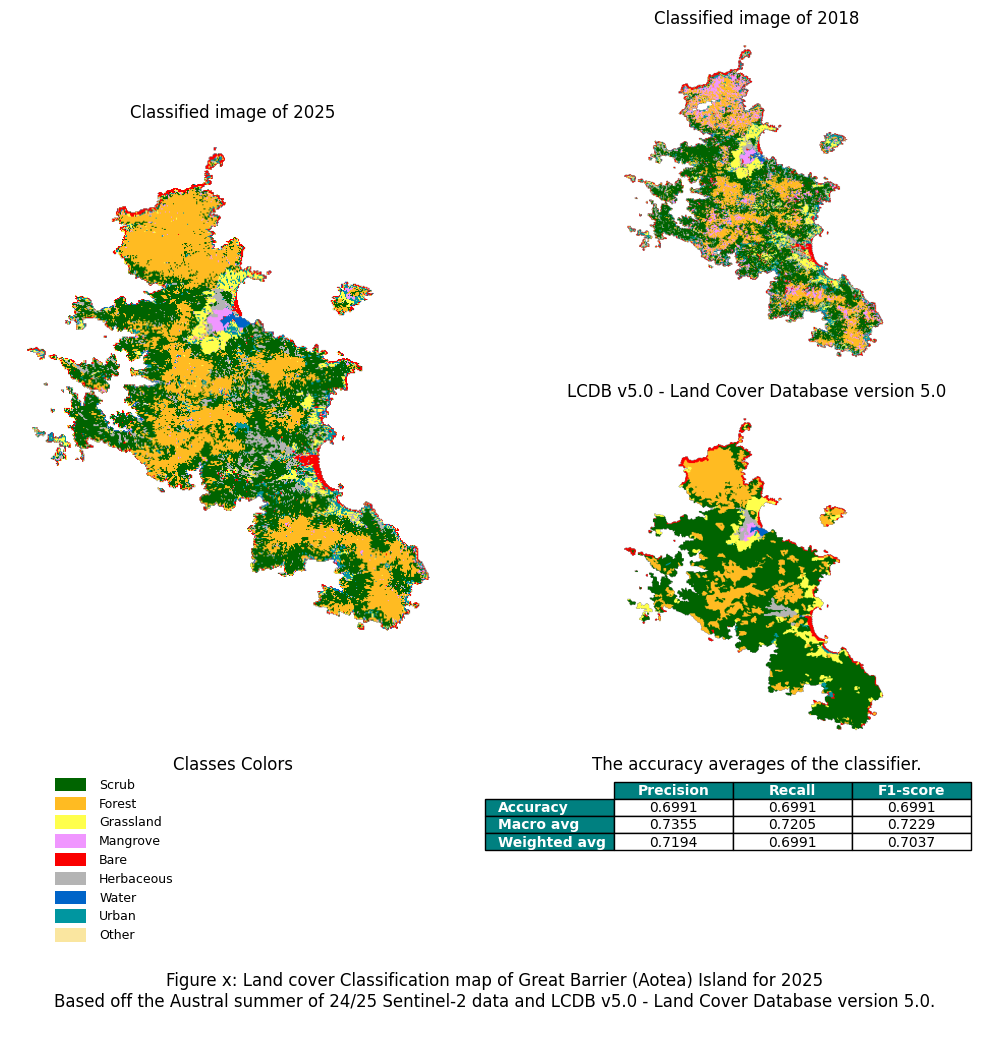

In [78]:
years = ['2025', '2018']
import matplotlib.colors as mcolors

# layout = [['A', 'A', 'B', 'B'],
#           ['C', 'C', 'D', 'D'],
#           ['E', 'E', 'E', 'E']]
# fig, axes = plt.subplot_mosaic(layout, figsize=(12, 10), height_ratios=[5,5,1])

# layout = [['A', 'A', 'A', 'A'],
#           ['B', 'B', 'C', 'C'],
#           ['D', 'D', 'D', 'D'],
#           ['E', 'E', 'E', 'E']]
# fig, axes = plt.subplot_mosaic(layout, figsize=(12, 10), height_ratios=[10, 5, 1, 1])

layout = [['A', 'A', 'B', 'B'],
          ['A', 'A', 'C', 'C'],
          ['D', 'D', 'E', 'E']]
fig, axes = plt.subplot_mosaic(layout, figsize=(10, 10), height_ratios=[5, 5, 3])

class_axe = [axes['A'], axes['B']]
based_axe = axes['C']
ledgend_axe = axes['D']
report_axe = axes['E']

colors = ['#' + v for v in classPalette]
# Create the custom colormap
cmap = mcolors.ListedColormap(colors)

for idx, axe in enumerate(class_axe):
    axe.set_title(f'Classified image of {years[idx]}')
    axe.imshow(classified_imgs[idx], extent=[xmin, xmax, ymin, ymax], cmap=cmap, vmin=1, vmax=10)
    axe.axis('off')  # Hide the axes

# LEDGEND
# Loop through the labels and colors to create squares and text
for i, (color, class_name) in enumerate(zip(classPalette, classNames)):
    spacing = 0.14
    # Create a colored square patch
    y_position = (10 - i) * spacing
    rect = patches.Rectangle((0.1, y_position), 0.07, 0.1, facecolor=f'#{color}', edgecolor='none')
    ledgend_axe.add_patch(rect)

    # Add the text label beside the square
    # The y-coordinate is also based on y_position
    ledgend_axe.text(0.2, y_position + 0.05, class_name, va='center', ha='left', fontsize=9)

    ledgend_axe.set_xlim(0, 1)
    ledgend_axe.set_ylim(0, 1.5)
    ledgend_axe.axis('off')
ledgend_axe.set_title('Classes Colors')
    
# Based image
based_axe.imshow(based_img, extent=[xmin, xmax, ymin, ymax], cmap=cmap, vmin=10, vmax=100)
based_axe.set_title('LCDB v5.0 - Land Cover Database version 5.0')
based_axe.axis('off')  # Hide the axes

# REPORT TABLE
report_axe.axis('off') # Hide the axes
report_axe.set_title('The accuracy averages of the classifier.')

# formant float values in the table
df_plot = df_plot.applymap(lambda x: f'{x:.4f}' if isinstance(x, (int, float)) else x)

# Create the table
table = report_axe.table(
    cellText=df_plot.values,
    colLabels=df_plot.columns.str.capitalize(),
    rowLabels=df_plot.index.str.capitalize(),
    loc='best',
    cellLoc='center'
)

table.scale(0.8, 0.8)  # Adjust table size

# Make headers bold
for (i, j), cell in table.get_celld().items():
    if i == 0 or j == -1: # Row 0 is the header, column -1 is the index
        cell.set_text_props(weight='bold', color='w')
        cell.set_facecolor('teal') # Header color

caption = '''
Figure x: Land cover Classification map of Great Barrier (Aotea) Island for 2025\nBased off the Austral summer of 24/25 Sentinel-2 data and LCDB v5.0 - Land Cover Database version 5.0.
'''
plt.figtext(0.5, -0.03, caption, wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show() 